# **5. Classification:**

## Objectives

## Inputs

## Outputs


---

# Change working directory

Change the working directory from its current folder to its parent folder
* Access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/heritage-housing-mvp/jupyter_notebooks'

Make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You have set a new current directory")

You have set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/heritage-housing-mvp'

---

# Load the data

In [4]:
import numpy as np
import pandas as pd
df1 = pd.read_csv("/workspace/heritage-housing-mvp/outputs/datasets/collection/house_prices_records.csv")
print(df1.shape)
df1.head(3)

(1460, 24)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500


---

Based on the dataset characteristics and the strengths and weaknesses of each algorithm, the following regression algorithms are chosen for building a model that predicts house sale prices accurately:
1. RandomForestRegressor
    * Rationale: This model is robust, reduces overfitting by averaging multiple decision trees, and handles large datasets with many features effectively. It also provides feature importance metrics, which helps in understanding the influence of each feature.
2. GradientBoostingRegressor
    * Rationale: This model improves performance through boosting, which sequentially reduces errors and handles non-linear relationships effectively. It is particularly useful for datasets with intircate patterns, such as housing data.
3. XGBRegressor
    * Rationale: XGBoost is known for its efficiency and high performance. It includes advanced features like regularization to prevent overfitting and is capable of handling large datasets with complex interactions between features, making it a strong candidate for predicting house prices accurately.

# ML Pipeline with all data

#### ML pipeline for data cleaning and feature engineering

In [5]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropFeatures
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from feature_engine import creation
from feature_engine.encoding import OrdinalEncoder
from feature_engine.outliers import Winsorizer
from feature_engine.transformation import LogTransformer, PowerTransformer
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression

def PipelineOptimization(model):
    pipeline_base = Pipeline([
        ('median', MeanMedianImputer(imputation_method='median',
                                variables=['LotFrontage','GarageYrBlt','MasVnrArea','2ndFlrSF']) ),

        ('drop', DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF']) ),

        ('categorical', CategoricalImputer(imputation_method='missing',
                                fill_value='None',
                                variables=['BsmtFinType1', 'GarageFinish']) ),
    
        ('mean', MeanMedianImputer(imputation_method='mean',
                                variables=['BedroomAbvGr']) ),
    
        ('winsorizer', Winsorizer(capping_method='iqr', fold=1.5, tail='both', variables=[
                            'GarageArea', 'LotArea', 'LotFrontage', 'MasVnrArea',
                            'OpenPorchSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF']) ),
    
        ('OrdinalCategoricalEncoder', OrdinalEncoder(encoding_method='arbitrary',
                                                    variables = ['BsmtExposure',
                                                                'BsmtFinType1',
                                                                'GarageFinish',
                                                                'KitchenQual']) ),
    
        ('lt', LogTransformer(variables = ['1stFlrSF']) ),
    
        ('power', PowerTransformer(variables= ['2ndFlrSF',
                                        'BsmtUnfSF',
                                        'GarageArea',
                                        'MasVnrArea',
                                        'TotalBsmtSF']) ),

        ('boxcox', PowerTransformer(variables=['GrLivArea', 'LotFrontage', 'LotArea']) ),

        ('yeo_johnson', PowerTransformer(variables=['BedroomAbvGr', 'GarageYrBlt', 'OpenPorchSF']) ),

        ('SmartCorrelatedSelection', SmartCorrelatedSelection(variables=None,
        method='spearman', threshold=0.7, selection_method='variance')),

        ('feat_scaling', StandardScaler() ),

        ('feat_selection', SelectFromModel(model) ),

        ("model", model ),
    ])

    return pipeline_base

/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Custom Class for Hyperparameter Optimisation

* Code is copied from walkthrough project prepared by Code Institute.

In [6]:
from sklearn.model_selection import GridSearchCV

class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineOptimization(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                            verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                    'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

### Split into train and validation set

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df1.drop(['SalePrice'], axis=1),
    df1['SalePrice'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1168, 23) (1168,) (292, 23) (292,)


---

# Grid Search CV - Sklearn

Use default hyperparameters to find most suitable algorithm

In [8]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(random_state=0),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=0),
    'XGBRegressor': XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    'RandomForestRegressor': {},
    'GradientBoostingRegressor': {},
    'XGBRegressor': {},
}

Make a hyperparameter optimization search using default hyperparameters

In [9]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In

Check the results produced

In [10]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
0,LinearRegression,0.735689,0.808533,0.861129,0.046141
2,GradientBoostingRegressor,0.618883,0.776389,0.835505,0.082563
1,RandomForestRegressor,0.686912,0.769305,0.825988,0.053874
3,XGBRegressor,0.588908,0.659939,0.711843,0.044739


The client's business requirement is an R2 score of at least 0.75
The best results were from GradientBoostingRegressor. Therefore further extensive search will be conducted on that particular estimator.

### Extensive search

In [11]:
models_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    }

params_search = {
    "GradientBoostingRegressor": {'model__n_estimators': [100,50,140],
                                'model__learning_rate': [0.1, 0.01, 0.001],
                                'model__max_depth': [3, 15, None],
                                'model__min_samples_split': [2,50],
                                'model__min_samples_leaf': [1, 50],
                                'model__max_leaf_nodes': [None, 50],

    },
}

Do a hyperparameter optimization search using default hyperparameters

In [12]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa

Check results

In [13]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
8,GradientBoostingRegressor,0.738575,0.801068,0.849812,0.038781,0.1,3,None,50,2,140
20,GradientBoostingRegressor,0.738575,0.801068,0.849812,0.038781,0.1,3,50,50,2,140
23,GradientBoostingRegressor,0.738575,0.801068,0.849812,0.038781,0.1,3,50,50,50,140
11,GradientBoostingRegressor,0.738575,0.801068,0.849812,0.038781,0.1,3,None,50,50,140
9,GradientBoostingRegressor,0.737223,0.799647,0.848089,0.038881,0.1,3,None,50,50,100
...,...,...,...,...,...,...,...,...,...,...,...
160,GradientBoostingRegressor,0.036191,0.058851,0.073998,0.012449,0.001,3,50,1,50,50
151,GradientBoostingRegressor,0.040587,0.056444,0.068839,0.009194,0.001,3,None,50,2,50
166,GradientBoostingRegressor,0.040587,0.056444,0.068839,0.009194,0.001,3,50,50,50,50
163,GradientBoostingRegressor,0.040587,0.056444,0.068839,0.009194,0.001,3,50,50,2,50


Extensive search with parameters has improved the models performance.

---

Establish the best model

In [14]:
best_model = grid_search_summary.iloc[0,0]
best_model

'GradientBoostingRegressor'

Parameters for best model

In [15]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 50,
 'model__min_samples_split': 2,
 'model__n_estimators': 140}

Define the best regressor, based on search

In [16]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('median',
                 MeanMedianImputer(variables=['LotFrontage', 'GarageYrBlt',
                                              'MasVnrArea', '2ndFlrSF'])),
                ('drop',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('categorical',
                 CategoricalImputer(fill_value='None',
                                    variables=['BsmtFinType1',
                                               'GarageFinish'])),
                ('mean',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['BedroomAbv...
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                                     'MasVnrArea',
         

---

# Assess the feature importance

Code has been adjusted from Code Institute's churnometer project.

* These are the 3 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'TotalBsmtSF']


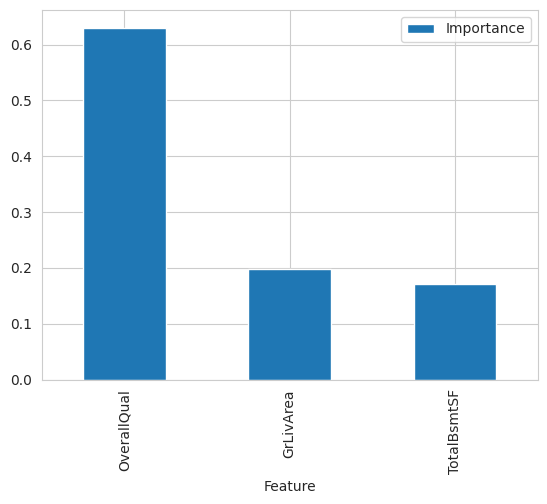

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

data_cleaning_feat_eng_steps = 11
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

print(f"* These are the {len(best_features)} most important features in descending order. "
    f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

These are the 3 most important features. The model was trained on them: OverallQual, GrLivArea and TotalBsmtSF.

**Evaluate performance on Train and Test sets:**

In [18]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)

def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
    print("\n")

def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

Model Evaluation 

* Train Set
R2 Score: 0.834
Mean Absolute Error: 21359.496
Mean Squared Error: 1024460750.793
Root Mean Squared Error: 32007.198


* Test Set
R2 Score: 0.761
Mean Absolute Error: 24335.071
Mean Squared Error: 1648866814.119
Root Mean Squared Error: 40606.241




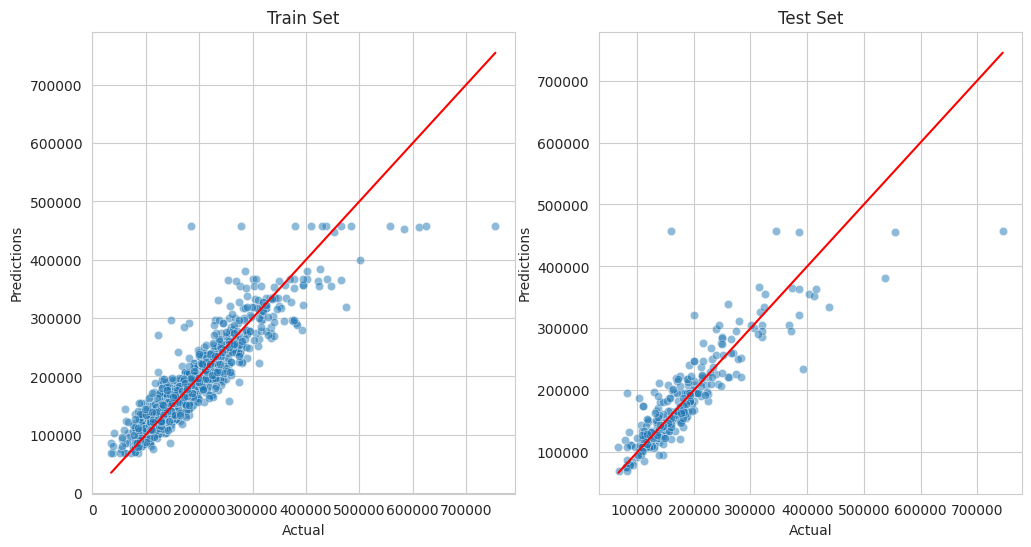

In [19]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

# Regressor with PCA

Explore potential values for PCA n_components

In [20]:
pipeline = PipelineOptimization(model=LinearRegression())
pipeline_pca = Pipeline(pipeline.steps[:3])
df_pca = pipeline_pca.fit_transform(df1.drop(['SalePrice'], axis=1))

print(df_pca.shape, '\n', type(df_pca))

(1460, 21) 
 <class 'pandas.core.frame.DataFrame'>


Apply PCA separately to the scaled data

In [22]:
import numpy as np
from sklearn.decomposition import PCA

n_components = 17

def pca_components_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)

    ComponentsList = ["Component" + str(number) for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index = ComponentsList,
        columns=['Explained Variance Ratio (%)'])
    
    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=dfExplVarRatio, marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()

pca_components_analysis(df_pca=df_pca, n_components=n_components)

ValueError: could not convert string to float: 'No'

In [ ]:
n_components = 7
pca_components_analysis(df_pca=df_pca, n_components=n_components)